In [1]:
!pip install diffrax


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.2/193.2 kB 4.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.7/177.7 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 4.3 MB/s eta 0:00:00


In [3]:
import jax
import jax.numpy as jnp
import diffrax
import matplotlib.pyplot as plt
import optimistix as optx
import equinox
import numpy as np
from jax.numpy import trapezoid
from functools import partial
import time
import torch
import os
import time as time
from functools import partial
import flax.nnx as nnx
import numpy as np
import optax

In [4]:
backend = jax.devices()[0].platform
print(backend)
device_jax = jax.devices()[0]
print(device_jax)
jax.config.update("jax_platform_name", backend)
device_torch = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device_torch)

INFO:2025-09-15 21:27:31,851:jax._src.xla_bridge:924: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-09-15 21:27:31,865:jax._src.xla_bridge:924: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


gpu
cuda:0
cuda


In [5]:
##########################################
# 1. Define the ODE
##########################################
def ode_system(t, x, args):
    (g,) = args
    x1, x2 = x
    # x1' = -x2,  x2' = x1 - mu*(1 - x1**2)*x2
    return jnp.array([
        x2,
        -(x1**5 -x1**3 +g*x1)-0.5*x2
    ])

minx=-1.5
maxx=1.5
miny=-1.5
maxy=1.5
domain=((minx,maxx),(miny,maxy))
maxnorm = jnp.sqrt(maxx**2 + maxy**2)
g=0.125
mu=1.0
delta=jnp.pi/3
args=(g,)


In [6]:
##########################################ss
# 2. Create a steady-state event
##########################################
# This condition returns a value that becomes less than zero once ||f(t,y)|| < atol + rtol * ||y||
near_origin_equil = diffrax.steady_state_event(
    rtol=1e-6,  # Make this smaller for more precise equilibrium detection
    atol=1e-6,  # Make this smaller for more precise equilibrium detection
    norm=lambda z: jnp.linalg.norm(z, ord=2)
)
def non_origin_equilibrium_event(t, y, args, **kwargs):
    # Compute derivatives at current point
    dy_dt = ode_system(t, y, args)
    # Get the norm of derivatives
    derivative_norm = jnp.linalg.norm(dy_dt, ord=2)
    
    # Check if point is near origin
    distance_from_origin = jnp.linalg.norm(y, ord=2)
    
    # Only return negative value when:
    # 1. Derivative is small enough (system not changing much) AND
    # 2. Distance from origin is NOT small (not at the trivial equilibrium)
    
    # Thresholds
    derivative_threshold = 1e-4
    origin_threshold = 1  # Points closer than this to origin are excluded
    
    # Check if derivatives are small (equilibrium condition)
    is_equilibrium = derivative_norm < derivative_threshold
    # Check if point is far enough from origin
    is_away_from_origin = distance_from_origin > origin_threshold
    
    # Return negative value only when both conditions are met
    return jax.lax.cond(
        is_equilibrium & is_away_from_origin,
        lambda _: True,  # If both conditions are met, return negative (trigger event)
        lambda _: False,  # Otherwise, return positive (don't trigger event)
        operand=None
    )

# Add a condition to detect if values have grown too large (divergence)
def overflow_event(t, y, args, **kwargs):
    # Check if any value has exceeded our threshold
    max_allowed = 1e5 # Maximum allowed value: 10^5
    max_value = jnp.max(jnp.abs(y))
    # Return negative value when the max value exceeds our threshold
    return max_allowed - max_value

# Use both the equilibrium event and the overflow event
steady_event = diffrax.Event(cond_fn={0: near_origin_equil,1: overflow_event,2:non_origin_equilibrium_event})

controller = diffrax.PIDController(rtol=1e-7, atol=1e-7)

system = diffrax.ODETerm(ode_system)
solver = diffrax.Dopri8()


@partial(jax.jit, backend=backend)
@jax.vmap
def omega(x: jax.Array):
    return jnp.sum(x**2)



In [7]:
def batched_solve(num_points:int, batch_size:int, t0:jax.Array, t1:jax.Array,
                  domain:tuple[tuple],
                  system:diffrax.ODETerm,
                  solver:diffrax.AbstractSolver,
                  controller:diffrax.PIDController,
                  term_cond:diffrax.Event,
                  dti:float,
                  max_steps:int,
                  args:tuple,
                  omega:callable,
                  beta:callable,
                  key:jax.random.key) -> tuple[jax.Array,jax.Array]:

    step = num_points // batch_size

    @partial(jax.jit, backend=backend)
    @partial(jax.vmap, in_axes=(0,0))
    def integration(ys:jax.Array, ts:jax.Array) -> tuple[jax.Array,jax.Array,jax.Array]:
        yssq = omega(ys)
        is_valid = ~jnp.isinf(ts)
        integral = trapezoid(
            jnp.where(is_valid, yssq, 0.0),
            jnp.where(is_valid, ts, 0.0)
        )
        result = beta(integral)
        return result, ys[0,0], ys[0,1]

    @partial(jax.jit, backend=backend)
    @partial(jax.vmap, in_axes=(0,))
    def solver_(y0:jax.Array) -> tuple[jax.Array,jax.Array,jax.Array]:
        sol = diffrax.diffeqsolve(
            terms=system,
            solver=solver,
            t0=t0,
            t1=t1,
            dt0=dti,
            y0=y0,
            args=args,
            event=term_cond,
            max_steps=max_steps,
            saveat=diffrax.SaveAt(t0=True, steps=True),
            stepsize_controller=controller,
            throw=False)
        return sol.ys, sol.ts, sol.event_mask[0]

    def scan_fn(carry, _):
        key = carry
        key, key1, key2 = jax.random.split(key, 3)
    
        # sample init conditions
        x = jax.random.uniform(key1, (batch_size, 1), minval=domain[0][0], maxval=domain[0][1])
        y = jax.random.uniform(key2, (batch_size, 1), minval=domain[1][0], maxval=domain[1][1])
        init = jnp.concatenate((x, y), axis=1)
    
        # solve ODE
        ys, ts, mask = solver_(init)   # shapes: (batch_size, steps, dim), (batch_size, steps), (batch_size,)
    
        # --- Instead of slicing with mask ---
        # pick first step always (for consistency)
        y0_x1 = ys[:, 0, 0]
        y0_x2 = ys[:, 0, 1]
    
        # do integration for every trajectory
        int_results, _, _ = integration(ys, ts)
    
        # select either:
        #   - integrated value (if mask == True)
        #   - 1.0 as "fallback" (if mask == False)
        r_batch = jnp.where(mask, int_results, 1.0)
        x_batch = y0_x1
        y_batch = y0_x2
    
        return key, (x_batch, y_batch, r_batch)


    # run scan
    key, (xs, ys, rs) = jax.lax.scan(scan_fn, key, None, length=step)

    # flatten to (num_points,)
    xs = xs.reshape(-1, 1)
    ys = ys.reshape(-1, 1)
    rs = rs.reshape(-1)

    # match original return format
    coords = jnp.concatenate((xs, ys), axis=1)
    return coords, rs


In [8]:

NUM_POINTS=3_000
Batch_size=300
time1=time.time()
f1=lambda x: 1-jnp.exp(-0.1*x)
f2=lambda x: jnp.tanh(0.1*x)
for _ in range(1):
    RESULTS = batched_solve(NUM_POINTS, batch_size=Batch_size, t0=0.0, t1=jnp.inf,
                    domain=domain,
                    system=system,
                    solver=solver,
                    controller=controller,
                    term_cond=steady_event,
                    dti=0.1,
                    max_steps=1000,
                    args=args,
                    omega=omega,
                    beta=f2,
                    key=jax.random.key(0))
time2=time.time()
print("Time taken for {} points: {:.4f} seconds".format(NUM_POINTS, time2 - time1))


Time taken for 3000 points: 3.1380 seconds


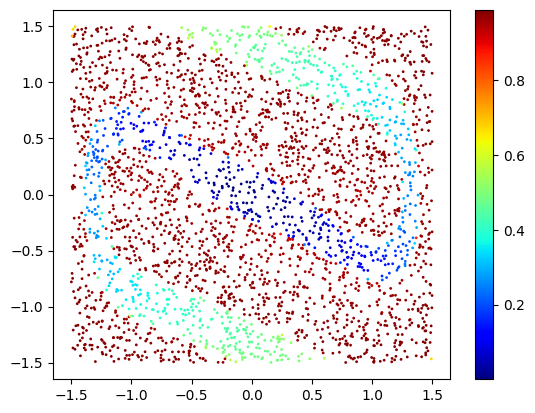

In [9]:
plt.figure()
plt.scatter(RESULTS[0][:,0], RESULTS[0][:,1], c=RESULTS[1], s=1, cmap="jet", vmin=jnp.min(RESULTS[1]), vmax=jnp.max(RESULTS[1]))
plt.colorbar()
plt.show()

In [16]:
backend = jax.devices()[0].platform
device_jax = jax.devices()[0]
jax.config.update("jax_platform_name", backend)

# @partial(jax.jit, static_argnames=("args"),backend=backend)
@partial(jax.vmap,in_axes=(0,None))
def system(x, args):
    # (mu,) = args
    (g,) = args
    x1, x2 = x[0], x[1]
    #! DEFINE THE DESIRED 2D SYSTEM
    # SYSTEM: x1' = -x2,  x2' = x1 - mu*(1 - x1**2)*x2
    return jnp.array([
        x2,
        -(x1**5 -x1**3 +g*x1)-0.5*x2
    ])
    # return jnp.array([x2, -(x1**5-x1**3+g*x1)-0.5*x2])



# @partial(jax.jit, backend=backend)
@jax.vmap
def omega(x: jax.Array):
    return jnp.sum(x**2)

# @partial(jax.jit, backend=backend)
def psi(x: jax.Array):
    return 0.1*(1+x)


class Net(nnx.Module):
    def __init__(self,din:int,layers_width:list[int],dout:int=1,*,rngs: nnx.Rngs):
        self.din = din
        self.dout = dout
        self.rngs = rngs
        self.layers_width = layers_width
        self.layers = [nnx.Linear(in_features=din, out_features=layers_width[0], rngs=self.rngs)]
        for i in range(1,len(layers_width)):
            self.layers.append(nnx.Linear(in_features=layers_width[i-1], out_features=layers_width[i], rngs=self.rngs))
        self.out = nnx.Linear(in_features=layers_width[-1], out_features=dout, rngs=self.rngs)        

    # @nnx.jit
    def __call__(self,x: jax.Array):  #&# This will be jitted once during training because we use it 
        for layer in self.layers:     #&# for the data points only 
            x = layer(x)
            x = nnx.tanh(x)
        return self.out(x).squeeze()  
    
    # @nnx.jit                              #&# This will be jitted once during training because we use it
    @partial(nnx.vmap,in_axes=(None,0))   #&# for the collocations points only
    def value_and_gradient(self, x):      
        val_,grad_ = nnx.value_and_grad(self.__call__)(x)
        return val_,grad_
    
# @jax.jit
def jacobian_fn(model):
    return nnx.vmap(nnx.grad(model))


# @jax.jit
def dot_vector(x, y):
    return jnp.sum(x * y, axis=1)



In [17]:

@partial(nnx.jit, static_argnames=("system", "omega", "psi", "args"))
def Zubov_training(col_points:jax.Array,
                   data_points:tuple[jax.Array, jax.Array],
                   system:callable, model:Net, 
                   omega:callable,
                   psi:callable,
                   args:tuple,
                   optimizer:optax.GradientTransformation) -> jax.Array:
    """Physics-informed neural network training using Zubov's method.
    The PDE to be solve is DW · f = -ω ψ(W)(1 - W) where W is the neural network function and DW the 
    gradient of W with respect to x. The loss is the sum of the PDE loss and the data loss.
    The PDE loss is computed at the collocation points and the data loss at the data points.
    We also impose the boundary loss by setting W(0)=0. The boundary loss is computed for each batch.

    Args:
        col_points (jax.Array): the points wherer the loss of the PDE is computed 
        data_points (tuple[jax.Array, jax.Array]): the points and values of the data loss
        system (callable): The dynamical system in format: system(x,args):x1,x2=x[0],x[1]...return jnp.array([f1(x),f2(x)])
        model (Net): The neural network model, an nnx.Module child
        omega (callable): ω(x) (see above equation)
        psi (callable): ψ(W(x)) (see above equation)
        args (tuple): args for the system function
        optimizer (optax.GradientTransformation): optax optimizer, it must have been initialized with the model
    """
    
    
    def Zubov_data_loss(model:nnx.Module):
        x_zeros=jnp.zeros(2)
        COLLOC_MODEL,GRAD_MODEL= model.value_and_gradient(col_points) # type: ignore
        COLLOC_SYS=system(col_points,args)
        COLLOC_OMEGA=omega(col_points)
        ZEROS_MODEL=model(x_zeros) # type: ignore
        DATA_MODEL=model(data_points[0]) # type: ignore

        
        zubov_loss=(dot_vector(GRAD_MODEL,COLLOC_SYS)+psi(COLLOC_MODEL)*COLLOC_OMEGA*(1-COLLOC_MODEL))**2 + ZEROS_MODEL**2
        zubov_loss_batch=jnp.mean(zubov_loss)
        data_loss=(DATA_MODEL-data_points[1])**2
        data_loss_batch=jnp.mean(data_loss) 
        loss_batch=data_loss_batch+zubov_loss_batch
        return loss_batch
    
    loss, grads = nnx.value_and_grad(Zubov_data_loss)(model)
    optimizer.update(grads) # type: ignore
    return loss


In [18]:

num_points=3_200_000
batch_size=32
batch_size_len=num_points//batch_size
minx=-1.5
maxx=1.5
miny=-1.5
maxy=1.5
domain=((minx,maxx),(miny,maxy))

model1=Net(2,[30,30,30,30],dout=1,rngs=nnx.Rngs(1100))
optimizer1=nnx.Optimizer(model1, optax.adam(learning_rate=1e-3),wrt=nnx.Param)
args=(1.0,)
args=(0.125,)

In [20]:

########### FURTHER OPTIMIZATION THROUGH jax.fori_loop FOR THE TRAINING LOOP ############
#^############# SPEEDUP 2X for CPU and 10X for GPU compared to the for loop  #^#############

model3=Net(2,[30,30,30,30],dout=1,rngs=nnx.Rngs(1100))
optimizer3=nnx.Optimizer(model3, optax.adam(learning_rate=1e-3),wrt=nnx.Param)
data_points=RESULTS


In [21]:

def train_model(model:Net,optimizer:nnx.Optimizer, num_points:int,batch_size:int,
                data_points:tuple[jax.Array, jax.Array]
                , system:callable, omega:callable, psi:callable,
                domain:tuple[tuple], args:tuple, key:jax.random.key) -> tuple[Net,nnx.Optimizer,jax.Array]:
    
    """
    Train the model using Zubov's method. The training loop is implemented using jax.fori_loop for speedup.
    num_iterations is the number of iterations to train the model.Each iteration uses a new batch of 
    collocation points, produces from new keys spltted from the key.
    
    Args:
        model (Net): The neural network model, an nnx.Module child
        optimizer (nnx.Optimizer): The optimizer for the model
        num_points (int): The number of points to train the model
        batch_size (int): The number of points in each batch
        data_points (tuple[jax.Array, jax.Array]): The data points and values for the loss function
        system (callable): The dynamical system in format: system(x,args):x1,x2=x[0],x[1]...return jnp.array([f1(x),f2(x)])
        omega (callable): ω(x) (see above equation)
        psi (callable): ψ(W(x)) (see above equation)
        domain (tuple[tuple]): The domain of the system, in the format ((minx,maxx),(miny,maxy))
        args (tuple): args for the system function
        key (jax.random.key): The random key for jax
    """
    
    num_iterations = num_points // batch_size

    @nnx.jit
    def body_fn(i, state):
        modell, optimizer, loss, current_key = state
        current_key, key1, key2 = jax.random.split(current_key, num=3)
        x = jax.random.uniform(key1, (batch_size, 1), minval=domain[0][0], maxval=domain[0][1])
        y = jax.random.uniform(key2, (batch_size, 1), minval=domain[1][0], maxval=domain[1][1])
        xy = jnp.concatenate((x, y), axis=1)
        loss = loss.at[i].set(Zubov_training(xy, data_points, system, modell, omega, psi, args, optimizer))
        return modell, optimizer, loss, current_key
    
    loss=jnp.empty((num_iterations,),dtype=jnp.float32)
    
    model_final, optimizer_final, loss_final, _ = nnx.fori_loop(0, num_iterations, body_fn, 
                                                              (model, optimizer, loss, key), unroll=False)
    return model_final, optimizer_final, loss_final

(320000,)


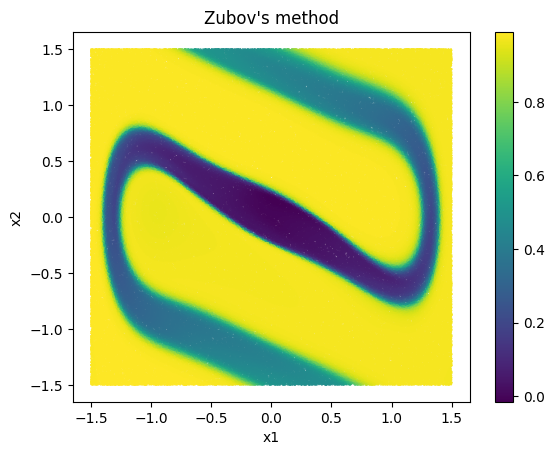

Time taken for training with jax.fori_loop: 53.03583025932312


In [22]:
for _ in range(1):
    time1 = time.time()
    model3, optimizer3, loss3 = train_model(model3, optimizer3, num_points, batch_size, data_points, 
                                            system, omega, psi, domain, args, jax.random.PRNGKey(0))
    x = jax.random.uniform(jax.random.key(1), (num_points//10, 1), minval=minx, maxval=maxx)
    y = jax.random.uniform(jax.random.key(4), (num_points//10, 1), minval=miny, maxval=maxy)
    xy = jnp.concatenate((x, y), axis=1)
    results = model3(xy)
    print(results.shape)
    plt.figure()
    plt.scatter(xy[:,0], xy[:,1], c=results, s=0.1, cmap="viridis", vmin=jnp.min(results), vmax=jnp.max(results))
    plt.colorbar()  
    plt.title("Zubov's method")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.show()
    time2 = time.time()
    print("Time taken for training with jax.fori_loop:", time2 - time1)

In [23]:

def plot_model_and_system(model, system, domain, args, num_points, plot_streamplot=True, figsize=(10, 8), 
                         cmap='viridis', contour_levels=50, alpha=0.7, streamplot_color='white',
                         density=1.0, linewidth=1.0, arrowsize=1.0, title=None,
                         show_colorbar=True, save_path=None, show_plot=True):
    """
    Plot the model evaluation as a contour plot and optionally overlay with the system's streamplot.
    
    Args:
        model: A function that takes points of shape (N, 2) and returns values of shape (N,).
        system: A function that takes points of shape (N, 2) and returns vectors of shape (N, 2).
        domain: A tuple of ((xmin, xmax), (ymin, ymax)) defining the plot domain.
        args: Parameters to pass to the system function.
        num_points: Number of points in each dimension for the grid.
        plot_streamplot: Boolean flag to include streamplot overlay.
        figsize: Figure size as a tuple (width, height).
        cmap: Colormap for the contour plot.
        contour_levels: Number of levels for the contour plot.
        alpha: Alpha transparency for the contour plot.
        streamplot_color: Color of the streamlines.
        density: Density of streamplot arrows.
        linewidth: Width of streamplot lines.
        arrowsize: Size of streamplot arrows.
        title: Title for the plot.
        show_colorbar: Whether to display the contour's colorbar (ignored if model is None).
        save_path: A file path to save the resulting figure, if provided.
        show_plot: If True, calls plt.show() at the end.
    
    Returns:
        fig, ax: The matplotlib figure and axis objects.
    """
    (xmin, xmax), (ymin, ymax) = domain
    
    # Use numpy.linspace for strictly equal spacing
    x = np.linspace(float(xmin), float(xmax), num_points)
    y = np.linspace(float(ymin), float(ymax), num_points)
    X, Y = np.meshgrid(x, y)
    
    # Ravel the meshgrid to create a JAX array of shape (num_points*num_points, 2)
    grid_points = jnp.stack([jnp.array(X.ravel()), jnp.array(Y.ravel())], axis=-1)
    
    if model is not None:
        # Forward pass through the model
        Z = model(grid_points).reshape(X.shape)
        
        # Create figure and axis
        fig, ax = plt.subplots(figsize=figsize)
        
        # Create contour plot
        contour = ax.contourf(X, Y, Z, levels=contour_levels, cmap=cmap, alpha=alpha)
        if show_colorbar:
            plt.colorbar(contour, ax=ax)
    else:
        # Create figure and axis
        fig, ax = plt.subplots(figsize=figsize)
    
    if plot_streamplot:
        # Compute vector field for streamplot
        vector_field = system(grid_points, args)
        
        # Reshape to separate U, V components
        U = vector_field[:, 0].reshape(X.shape)
        V = vector_field[:, 1].reshape(Y.shape)
        
        # Convert to numpy for matplotlib streamplot
        # Use 1D coordinate arrays for x and y (not the meshgrid)
        x_np = np.array(x)
        y_np = np.array(y)
        U_np = np.array(U)
        V_np = np.array(V)
        
        # Create streamplot - use 1D arrays for coordinates
        ax.streamplot(x, y, U, V, density=density, linewidth=linewidth, 
                     arrowsize=arrowsize, color=streamplot_color)
    
    if title:
        ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    if show_plot:
        plt.show()
    return fig, ax

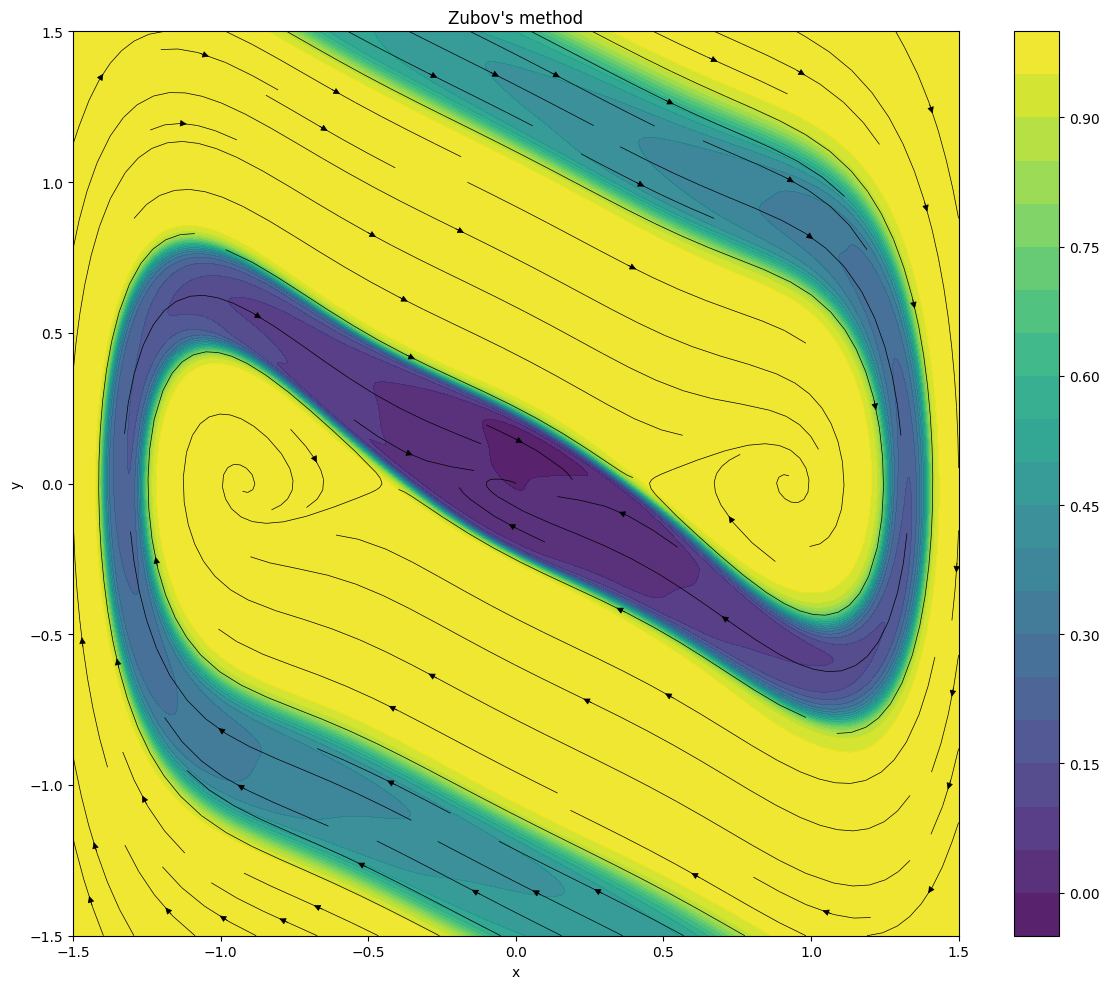

(<Figure size 1200x1000 with 2 Axes>,
 <Axes: title={'center': "Zubov's method"}, xlabel='x', ylabel='y'>)

In [24]:
plot_model_and_system(model3, system, domain,args,1000,streamplot_color="black",density=1,linewidth=0.5,
                      contour_levels=20,cmap="viridis",alpha=0.9,figsize=(12,10),title="Zubov's method")
